# A/B-тестирование

# Описание проекта

Оценка результатов A/B-теста. Оценка корректрности проведения теста, его результатов.  проверка правильности набора данных, пересечение событий из конкурирующего теста, рекламных компаний. Выявление проблем.


### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

# Загрузка и обзор данных

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import stats as st
import math as mth
from plotly import graph_objects as go

warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 1 
sns.set_theme(style="white", font_scale=1.3)

### Загрузка и обзор датасетов

In [2]:
try:
    final_ab_events = pd.read_csv('/datasets/final_ab_events.csv')
    ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
    final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    final_ab_events = pd.read_csv('datasets/final_ab_events.csv')
    ab_project_marketing_events = pd.read_csv('datasets/ab_project_marketing_events.csv')
    final_ab_new_users = pd.read_csv('datasets/final_ab_new_users.csv')
    final_ab_participants = pd.read_csv('datasets/final_ab_participants.csv')

In [3]:
print('final_ab_events')
display(final_ab_events.head())
final_ab_events.info()
print('')

print('ab_project_marketing_events')
display(ab_project_marketing_events.head())
ab_project_marketing_events.info()
print('')

print('final_ab_new_users')
display(final_ab_new_users.head())
final_ab_new_users.info()
print('')

print('final_ab_participants')
display(final_ab_participants.head())
final_ab_participants.info()

final_ab_events


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

ab_project_marketing_events


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

final_ab_new_users


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

final_ab_participants


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Есть пропуски и неверные типы данных, исправим

# Предобработка данных

### Привести типы

Дату в формат даты

In [4]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt']).dt.date
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

Числовые данные в числовой формат

In [5]:
final_ab_events['details'] = pd.to_numeric(final_ab_events['details'], errors='raise')

In [6]:
final_ab_events.info()
print('')

ab_project_marketing_events.info()
print('')

final_ab_new_users.info()
print('')

final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 6173

### Работа с  дубликатами

In [7]:
print('Дубликаты:')
print(final_ab_events.duplicated().sum())
print(ab_project_marketing_events.duplicated().sum())
print(final_ab_new_users.duplicated().sum())
print(final_ab_participants.duplicated().sum())

Дубликаты:
2
0
0
0


In [8]:
final_ab_events[final_ab_events.duplicated()]

,user_id,event_dt,event_name,details
41759,72C55C38CAE0B00B,2020-12-21,purchase,4.99
377026,72C55C38CAE0B00B,2020-12-21,login,NaN


Дубликаты отсутствуют

### Работа с  пропусками

In [9]:
print('Пропуски:')
print(final_ab_events.isna().sum())
print(ab_project_marketing_events.isna().sum())
print(final_ab_new_users.isna().sum())
print(final_ab_participants.isna().sum())

Пропуски:
user_id       0     
event_dt      0     
event_name    0     
details       377577
dtype: int64
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
user_id       0
first_date    0
region        0
device        0
dtype: int64
user_id    0
group      0
ab_test    0
dtype: int64


Есть пропуски в такблице final_ab_events, в колонке details. Эта колонка содержит дополнительные данные о событии. В данной таблице там хранится только стоимость покупки при ее совершении. Нет покупки- нет данных. Но на свякий случай, проверим это.

In [10]:
print(len(final_ab_events[(final_ab_events['event_name']!='purchase') & (final_ab_events['details'].isna())]))

377577


Количество пропусков для событий, не являющимися покупкой равно количеству пропусков в колонке 'details'.

### Работа с уникальными значениями

In [11]:
print(final_ab_events['event_name'].value_counts())
print(ab_project_marketing_events['regions'].value_counts())
print(final_ab_new_users['region'].value_counts())
print(final_ab_new_users['device'].value_counts())
print(final_ab_participants['group'].value_counts())
print(final_ab_participants['ab_test'].value_counts())

login           189552
product_page    125563
purchase        62740 
product_cart    62462 
Name: event_name, dtype: int64
APAC                        4
EU, CIS, APAC, N.America    3
EU, N.America               2
EU, CIS, APAC               2
CIS                         2
N.America                   1
Name: regions, dtype: int64
EU           46270
N.America    9155 
CIS          3155 
APAC         3153 
Name: region, dtype: int64
Android    27520
PC         15599
iPhone     12530
Mac        6084 
Name: device, dtype: int64
A    9655
B    8613
Name: group, dtype: int64
interface_eu_test          11567
recommender_system_test    6701 
Name: ab_test, dtype: int64


Все значния выглядят нормально.

In [12]:
print('final_ab_events - действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.')
display(final_ab_events.head(1))
print('')

print('ab_project_marketing_events - алендарь маркетинговых событий на 2020 год.')
display(ab_project_marketing_events.head(1))
print('')

print('final_ab_new_users - пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.')
display(final_ab_new_users.head(1))
print('')

print('final_ab_participants - таблица участников тестов.')
display(final_ab_participants.head(1))

final_ab_events - действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07,purchase,99.99



ab_project_marketing_events - алендарь маркетинговых событий на 2020 год.


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03



final_ab_new_users - пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC



final_ab_participants - таблица участников тестов.


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test


### Объединение таблиц

Нас интересуют только участиники тестов, поэтому объеденим таблицы по user_id только для тех, кто есть в таблице участников теста- final_ab_participants.

In [13]:
data = final_ab_participants.merge(final_ab_events, on='user_id', how='left')
data = data.merge(final_ab_new_users, on='user_id', how='left')
print(data.isna().sum())
display(data)
data.info()

user_id       0    
group         0    
ab_test       0    
event_dt      3743 
event_name    3743 
details       94952
first_date    0    
region        0    
device        0    
dtype: int64


,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25,purchase,4.99,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,product_cart,NaN,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25,product_cart,NaN,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,product_page,NaN,2020-12-07,EU,PC
...,...,...,...,...,...,...,...,...,...
110363,63FBE257B05F2245,A,interface_eu_test,2020-12-23,login,NaN,2020-12-20,EU,Android
110364,79F9ABFB029CF724,B,interface_eu_test,2020-12-14,login,NaN,2020-12-14,EU,PC
110365,79F9ABFB029CF724,B,interface_eu_test,2020-12-15,login,NaN,2020-12-14,EU,PC
110366,79F9ABFB029CF724,B,interface_eu_test,2020-12-16,login,NaN,2020-12-14,EU,PC


<class 'pandas.core.frame.DataFrame'>
Int64Index: 110368 entries, 0 to 110367
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     110368 non-null  object        
 1   group       110368 non-null  object        
 2   ab_test     110368 non-null  object        
 3   event_dt    106625 non-null  datetime64[ns]
 4   event_name  106625 non-null  object        
 5   details     15416 non-null   float64       
 6   first_date  110368 non-null  datetime64[ns]
 7   region      110368 non-null  object        
 8   device      110368 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 8.4+ MB


Есть пропуски по событиям. Видимо, есть пользователи, которые не совершали никаких действий во время теста. Проверим их чуть позже.

# Оценка корректности проведения теста

## Соответствие данных требованиям технического задания

#### Название теста: `recommender_system_test`

#### группы: А — контрольная, B — новая платёжная воронка

Значения в таблице соответствуют.

#### Дата запуска: 2020-12-07. Дата остановки: 2021-01-04. 
Проверим соответствие данных.

In [14]:
print(data[data['ab_test']=='recommender_system_test']['first_date'].min())
print(data[data['ab_test']=='recommender_system_test']['event_dt'].max())

2020-12-07 00:00:00
2020-12-30 00:00:00


Время совпадает. Но после 30 декабря событий не было, 5 дней тестовых данных не было. 

#### Дата остановки набора новых пользователей: 2020-12-21.

In [15]:
print(data[data['ab_test']=='recommender_system_test']['first_date'].max())

2020-12-21 00:00:00


Соответствует.

#### Ожидаемое количество участников теста: 6000

In [16]:
data[data['ab_test']=='recommender_system_test']['user_id'].nunique()

6701

Соответствует ТЗ.

#### Аудитория: 15% новых пользователей из региона EU

In [17]:
display(
    data
    [data['ab_test']=='recommender_system_test']
    .groupby('region')
    .agg({'user_id':'nunique'})
    .reset_index()
)

print(
    data[
        (data['region']=='EU') & 
        (data['ab_test']=='recommender_system_test')
    ]
    ['user_id']
    .nunique() / 
    final_ab_new_users[
        final_ab_new_users['region']=='EU'
    ]
    ['user_id']
    .nunique()*
    100
)

,region,user_id
0,APAC,72
1,CIS,55
2,EU,6351
3,N.America,223


13.725956343202938


В тест попали пользователи из других регионов. Их меньше 2% от общего числа. Если их отбросить, данные всё равно будут соответствовать ТЗ, ведь из EU больше 6000 пользователей. 

Аудитория составляет 13.7% от числа новых пользователей региона. В регионе больше новых пользователей, чем ожидалось.

In [18]:
ab_data = data[(data['region']=='EU') & (data['ab_test']=='recommender_system_test')]

## Совпадение с маркетинговыми активностями

#### Оставим маркетинговые мероприятия только интересующего нас региона.

In [19]:
ab_project_marketing_events = ab_project_marketing_events[
    ab_project_marketing_events['regions']
    .str.contains('EU', regex=True)
]

ab_project_marketing_events[ab_project_marketing_events['finish_dt'] >= ab_data['first_date'].min()]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


#### Проведение теста пересекается с рождественским/новогодним промо.
Проверим, есть ли изменение активности пользователей после 25 декабря.

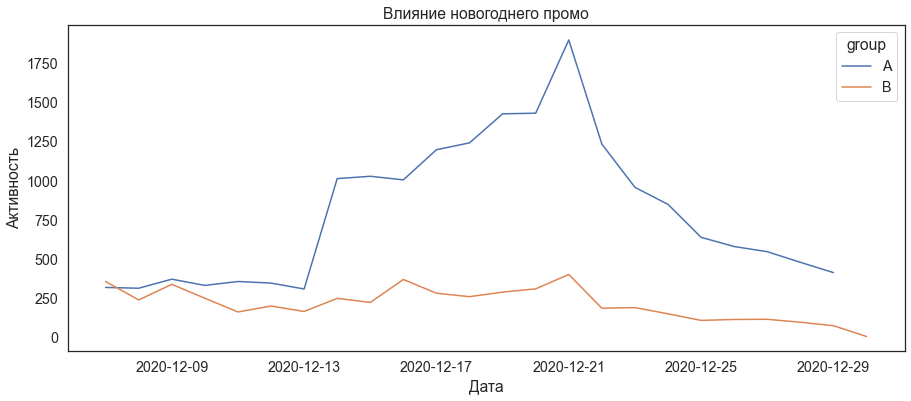

In [20]:
activity = (
    ab_data
    .groupby(['group', 'event_dt'])
    .agg({'user_id':'count'})
    .reset_index()
)

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=activity, x='event_dt', y='user_id', hue='group')

plt.title('Влияние новогоднего промо')
plt.xlabel('Дата')
plt.ylabel('Активность');

Никакого всплеска активности после 25 числа не наблюдается. Промо не оказывает влияния на группы.

## Проверка аудитории теста

#### Посмотрим на распределение пользователей по группам.

In [21]:
display(
    ab_data
    .groupby(['group'])
    .agg({'user_id':'nunique'})
    .reset_index()
)

,group,user_id
0,A,3634
1,B,2717


В группе А есть перевес но, часто, в целевых группах больше людей. Выглядит нормально.

Проверим, нет ли пользователей, попавших в обе группы.

In [22]:
user_group_table = ab_data.groupby('user_id').agg({'group':'nunique'}).reset_index()

print('Пользователей, участвовавших в обоих группах: {}'.format(len(user_group_table[user_group_table['group']>1])))

Пользователей, участвовавших в обоих группах: 0


Пользователи не пересекаются.

#### Проверим совпадение с другим тестом. 
Посколько мы не знаем ничего про второй тест, сложно оценить его влияние на первый. Для начала, можно посмотреть, сколько пользователей из второго теста, попавших в контрольную группу, попали внаш тест.

In [23]:
interface_eu_test_users = data[(data['ab_test']=='interface_eu_test') & (data['group']=='B')]['user_id']

cross_users = ab_data[ab_data['user_id'].isin(interface_eu_test_users)]

len(cross_users['user_id'].unique())

783

Немало. Посмотрим, как они распределены по группам нашего теста.

In [24]:
cross_users.groupby('group').agg({'user_id':'nunique'}).reset_index()

,group,user_id
0,A,439
1,B,344


Соотношение похожее, можно сказать, что пересечение пользователей в тестах не влияет на общую картину.

#### Оценим активность пользователей.

In [25]:
print(ab_data['event_name'].isna().sum())

ab_data['event_name'] = ab_data['event_name'].fillna('no_event')

2870


Довольно много пользователей без какой-либо активности в период теста.  Взглянем поближе.

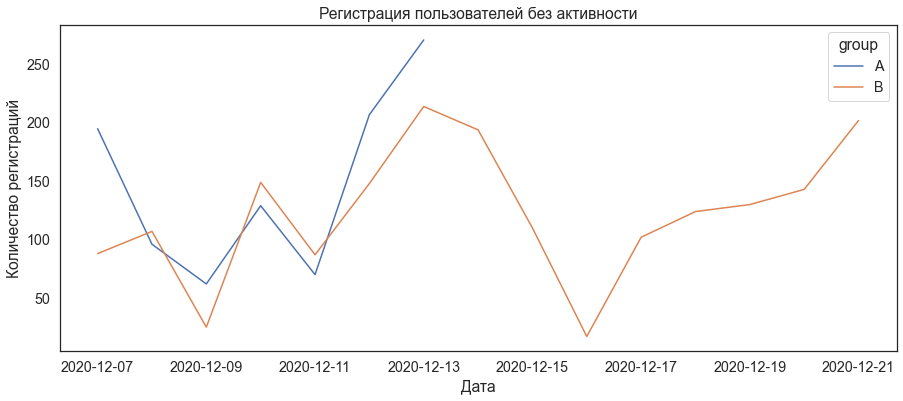

In [26]:
ab_activity = (
    ab_data
    [ab_data['event_name']=='no_event']
    .groupby(['group', 'first_date'])
    .agg({'user_id':'nunique'})
    .reset_index()
)


fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=ab_activity, x='first_date', y='user_id', hue='group')

plt.title('Регистрация пользователей без активности')
plt.xlabel('Дата')
plt.ylabel('Количество регистраций');

До 14 числа бользователей без активности в обоих группах было примерно поровну, но после 14 числа в группу А они перестали попадать. Можно только предполагать, почему так странно получилось: ошибка записи событий, невозможность зарегестрироваться на сайте после обновлений, проблемы с сервером. В данной ситуации остается лишь избавиться от всех неактивных пользователей.

In [27]:
no_event_max_date = ab_data[(ab_data['event_name']=='no_event') & (ab_data['group']=='A')]['first_date'].max()

ab_data = ab_data[ab_data['event_name']!='no_event']

print('Всего пользователей после фильтрации: {}'.format(len(ab_data['user_id'].unique())))

display(
    ab_data
    .groupby(['group'])
    .agg({'user_id':'nunique'})
    .reset_index()
)

Всего пользователей после фильтрации: 3481


,group,user_id
0,A,2604
1,B,877


Теперь в целевой группе еще меньше пользователей, но распределение 3:1 все еще нормальное. Пользователей сильно стало меньше, чем заявлено в ТЗ, но достаточно для проведение теста.

#### Изучение горизонта событий

Пользователей после фильтрации осталось мало, тест заканчивается раньше, чем в ТЗ, так что, стоит оценить важность горизонта событий именно в 14 дней. 

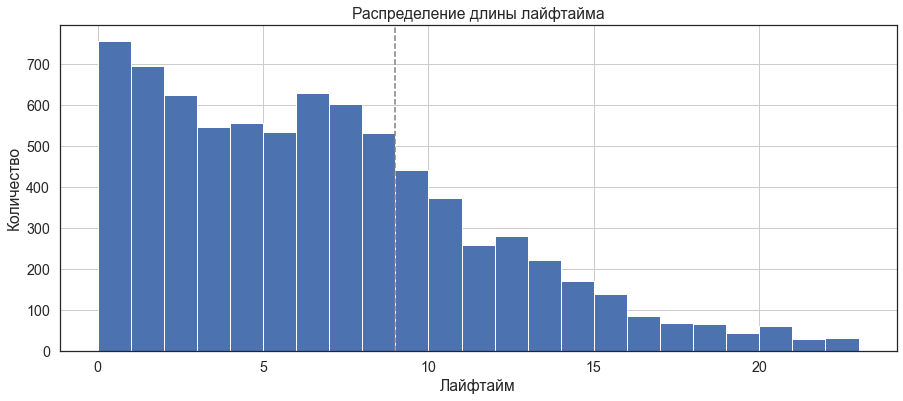

Длина лайфтайма событий у 75% пользователей: 9.0


In [28]:
lifetime = (
    ab_data
    .groupby(['user_id', 'event_name'])
    .agg({'first_date':'min', 'event_dt':'max'})
    .reset_index()
)

lifetime['lifetime'] = (lifetime['event_dt'] - lifetime['first_date']).dt.days.astype('int')

lifetime.hist('lifetime', bins=lifetime['lifetime'].max(), figsize=(15,6))

plt.axvline(x=lifetime['lifetime'].quantile(0.75),
            color='gray',
            linestyle='--')

plt.xlabel('Лайфтайм')
plt.ylabel('Количество')
plt.title('Распределение длины лайфтайма')
plt.show();

print('Длина лайфтайма событий у 75% пользователей: {}'.format(lifetime['lifetime'].quantile(0.75)))

In [29]:
ab_data = ab_data.merge(lifetime[['user_id', 'lifetime']], on='user_id')

horizont_rate = (ab_data['event_dt'].max() - timedelta(days=8)).date()

ab_data = ab_data.query('first_date <= @horizont_rate')

ab_data = ab_data.query('lifetime <= 14')

print('Всего пользователей после фильтрации: {}'.format(len(ab_data['user_id'].unique())))

Всего пользователей после фильтрации: 3227


## Промежуточный вывод

Данные не полностью согласуются с техническим заданием.  Названия групп, теста, временные рамки, регион и размер аудитории соответствуют заявленным до фильтрации. Горизонт событий уменьшен до 9  дней для увеличения размера выборки.

- После фильтрации оказалось, что выборка сократилась почти вдвое, многие пользователи не совершали действий по невыявленным причинам. 
- В выборку попали  пользователи из других регионов.
- В контрольной и целевой группе были пользователи из конкурирующего теста.
- Тест проводился по время промо-акции.

# Исследовательский анализ данных

#### Посмотрим на количество событий в группах.

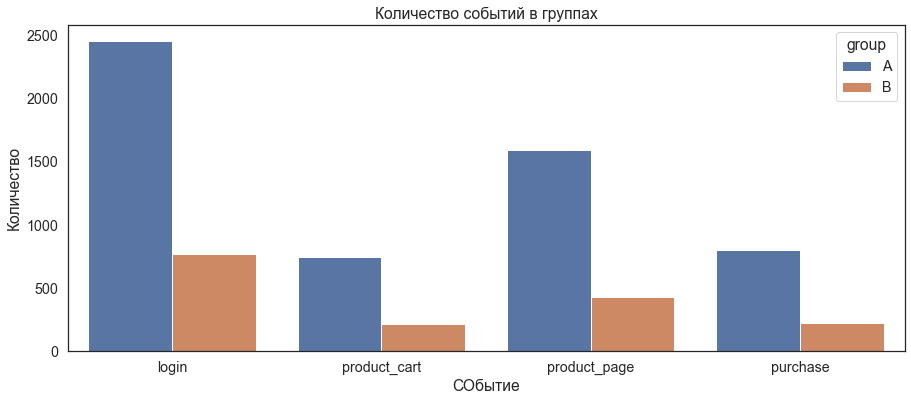

In [30]:
events_group = (
    ab_data
    .groupby(['group', 'event_name'])
    .agg({'user_id':'nunique'})
    .reset_index()
)

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=events_group, x='event_name', y='user_id', hue='group')

plt.title('Заголовок графика')
plt.xlabel(u'Название оси Х')
plt.ylabel(u'Название оси У')

plt.title('Количество событий в группах')
plt.xlabel('СОбытие')
plt.ylabel('Количество');

Распределение событий в группах соответствует численности групп. Всё выглядит нормально. 

#### Посмотрим на распределение событий по дням.

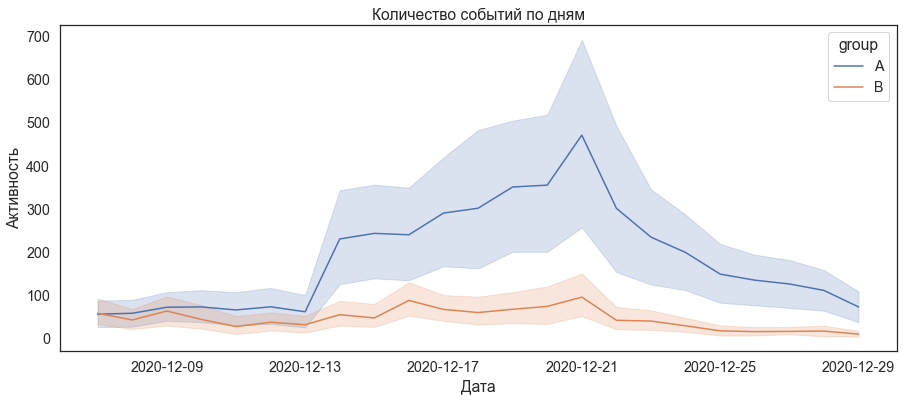

In [31]:
events_group = (
    ab_data
    .groupby(['group', 'event_name', 'event_dt'])
    .agg({'user_id':'nunique'})
    .reset_index()
)

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=events_group, x='event_dt', y='user_id', hue='group')

plt.title('Количество событий по дням')
plt.xlabel('Дата')
plt.ylabel('Активность');

Группы ведут себя похоже. 13 декабря наступает момент, после котого начинается бурная активность пользователей.

Для трех четвертей пользователей первое целевое событие происходит в течение 9 дней после регистрации. Примем это за горизонт событий для нашего теста.

#### Проверим распределение событий на пользователя в группах

In [32]:
events_users = (
    ab_data
    .groupby(['group', 'user_id'])
    .agg({'event_name':'nunique'})
    .reset_index()
)

display(events_users.head())

print('group A')
display(events_users[events_users['group']=='A'].describe())

print('group B')
display(events_users[events_users['group']=='B'].describe())

,group,user_id,event_name
0,A,0010A1C096941592,3
1,A,00341D8401F0F665,1
2,A,003DF44D7589BBD4,3
3,A,00505E15A9D81546,1
4,A,006E3E4E232CE760,2


group A


,event_name
count,2459.000000
mean,2.276129
std,0.841728
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,4.000000


group B


,event_name
count,768.000000
mean,2.132812
std,0.848692
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,4.000000


Проверяем количество уникальных событий у пользователей, потому что, в контексте этого исследования, нас интересует, посещал ли он конкретную страницу, а не сколько раз. Группы выглядят похожими.

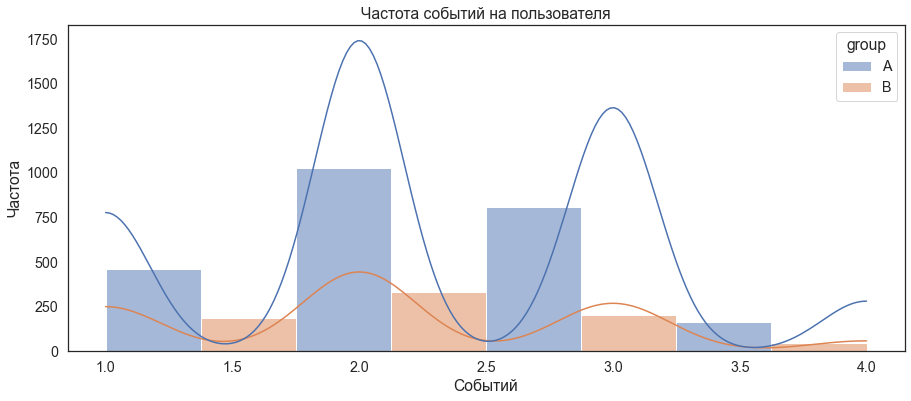

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.histplot(data=events_users, x='event_name', hue='group', bins=4, multiple='dodge', kde=True)

plt.title('Частота событий на пользователя')
plt.xlabel('Событий')
plt.ylabel('Частота');

В группе А пропорционально больше активности. В среднем. у пользователей изобоих групп по 2 события.

#### Проверим, как меняется конверсия в воронке в выборках на разных этапах

In [34]:
def get_conversion(group):
    conversion = (
        ab_data
        [ab_data['group']==group]
        .groupby('event_name')
        .agg({'user_id':'nunique'})
        .reset_index()
        .rename(columns={'user_id':'users'})
        .reindex([0, 2, 1, 3])
    )

    conversion['total'] = len(ab_data[ab_data['group']==group]['user_id'].unique())

    conversion['conversion'] = (conversion['users'] / conversion['total'] * 100).round(1)
    
    return conversion

In [35]:
conversion_a = get_conversion('A')
conversion_b = get_conversion('B')
display(conversion_a)
display(conversion_b)

,event_name,users,total,conversion
0,login,2459,2459,100.0
2,product_page,1591,2459,64.7
1,product_cart,748,2459,30.4
3,purchase,799,2459,32.5


,event_name,users,total,conversion
0,login,768,768,100.0
2,product_page,432,768,56.2
1,product_cart,218,768,28.4
3,purchase,220,768,28.6


В обоих группах покупок больше, чем добавлений товара в корзину. Это значит только то, что некоторые покупают без использования корзины. В группе В конверсия стабильно ниже, чем в группе А.

## Итоги исследовательского анализа

Распределение событий в группах пропорционально их размеру. 

Было принято решение уменьшить горизонт событий до 9 дней, потому что у большинства пользователей целевое действие происходило доэтого срока и нет смысла отсеивать еще больше людей, ведь выборка и без того сильно просела.

# Оценка результатов A/B-тестирования

Подготовим функцию

In [36]:
def z_test(event_name, alpha=0.05):

    users1 = conversion_a[conversion_a['event_name']==event_name]['users'].tolist()[0]
    users2 = conversion_b[conversion_b['event_name']==event_name]['users'].tolist()[0]
    total1 = conversion_a[conversion_a['event_name']==event_name]['total'].tolist()[0]
    total2 = conversion_b[conversion_b['event_name']==event_name]['total'].tolist()[0]
    
    p1 = users1 / total1
    p2 = users2 / total2

    p_combined = (users1 + users2) / (total1 + total2)
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total1 + 1/total2)) 
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2 
    print('p-значение: ', p_value)

    if (p_value < alpha): 
        print('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')

In [37]:
z_test('product_page')

p-значение:  2.3653023153658026e-05
Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия


Между конверсией в просмотр карточек товаров в группах есть статистически значимая разница. Причем, p-value близок к нулю.

In [38]:
z_test('product_cart')

p-значение:  0.28276690223194123
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет


Между конверсией в просмотр корзины в группах нет статистически значимой разницы. Причем, p-value очень сильно к единице, разница крайне мала.

In [39]:
z_test('purchase')

p-значение:  0.04526664615445464
Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия


Между конверсией в покупки в группах нет статистически значимой разницы.

# Выводы

Результаты исследования не соответствуют техническому заданию: конверсия значимо не изменилась (только в просмотр карточек товаров, но, судя по выборке, не в большую сторону).

#### Тест не был проведен корректно.
Множество неверных данных, ошибок при распределении пользователей, техничские проблемы, сильное сокращение участников исследования не дают повода назвать этот тест корректным.